<a href="https://colab.research.google.com/github/mori01-22/kennkyu/blob/main/Sample1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/mori01-22/kennkyu/blob/main/Sample1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# タンス検出 (二値分類) ノートブック

このノートブックは、与えられた画像（タンスあり / タンスなし）を識別するための学習・評価・推論パイプラインを示します。主に TensorFlow / Keras の転移学習（MobileNetV2）を利用します。

前提: 画像データはローカルに用意され、以下のようなフォルダ構成になっていることを想定します:

```
data/
  train/
    tansu/        # タンスが写っている画像（約1000枚程度）
    not_tansu/    # タンスが写っていない画像
```

(検証は自動で分割します)

ノート: このノートブックは Colab / ローカルどちらでも動きます。ローカル環境で GPU を使う場合は適切に TensorFlow をインストールしてください。

In [14]:
# 基本的なインポートと設定
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)

# 再現性のためのシード設定（任意）
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)

TensorFlow version: 2.20.0


In [15]:
# 設定: モデル保存先を明示的に切り替えられるようにするセル
# 注意: 自動で Drive をマウントするとブロッキングしてノートブックが応答しなくなることがあります。
# 必要なら手動でマウントしてから保存してください。

# True にすると Drive 配下に保存を試みる（ただし自動マウントは行いません）
SAVE_TO_DRIVE = False
# プロジェクト直下に保存を試みる場合は True
SAVE_TO_PROJECT_ROOT = True
# Drive 内のフォルダ（プロジェクト直下が見つからない場合のフォールバック）
DRIVE_SUBDIR = 'kennkyu_models'
# 明示的に絶対パスを指定したい場合はそれを使います（空文字列で無効）
FORCE_SAVE_PATH = ''


def find_project_root_by_git(start_dir=None, max_up=6):
    """Walk up from start_dir looking for a .git folder to identify repo root."""
    import os
    if start_dir is None:
        start_dir = os.getcwd()
    cur = os.path.abspath(start_dir)
    for _ in range(max_up):
        if os.path.isdir(os.path.join(cur, '.git')):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    return None


def find_repo_in_drive_by_name(repo_name):
    import os
    base = '/content/drive/MyDrive'
    if os.path.isdir(base):
        candidate = os.path.join(base, repo_name)
        if os.path.isdir(candidate):
            return candidate
    return None


def get_save_path(fname='tansu_detector.keras'):
    import os
    # 1) FORCE_SAVE_PATH が指定されていればそれを使う
    if FORCE_SAVE_PATH:
        return FORCE_SAVE_PATH

    # 2) まずプロジェクト直下保存を試みる（.git が見つかればそこをルートとみなす）
    if SAVE_TO_PROJECT_ROOT:
        proj_root = find_project_root_by_git()
        if proj_root and os.access(proj_root, os.W_OK):
            return os.path.join(proj_root, fname)

    # 3) Colab 判定（google.colab が存在するか、/content が存在するか）
    try:
        shell = str(get_ipython())
        is_colab = 'google.colab' in shell or os.path.exists('/content')
    except Exception:
        is_colab = os.path.exists('/content')

    # 4) Colab + DRIVE 保存を選んだ場合: Drive が既にマウントされているか確認して保存
    if SAVE_TO_DRIVE and is_colab:
        # NOTE: do NOT call drive.mount() automatically (it can block in some environments).
        drive_base = '/content/drive'
        if os.path.isdir(drive_base):
            # Try to locate a folder in Drive with same repo name
            repo_name = os.path.basename(os.getcwd())
            drive_repo = find_repo_in_drive_by_name(repo_name)
            if drive_repo and os.access(drive_repo, os.W_OK):
                return os.path.join(drive_repo, fname)
            # fallback: use a dedicated folder in Drive
            drive_folder = os.path.join(drive_base, 'MyDrive', DRIVE_SUBDIR)
            os.makedirs(drive_folder, exist_ok=True)
            return os.path.join(drive_folder, fname)
        else:
            # Drive not mounted; return a clear path in /content and warn the user
            tmp_path = os.path.join('/content', fname)
            print('WARNING: SAVE_TO_DRIVE=True but /content/drive not mounted.\nPlease mount Drive manually in Colab (or set SAVE_TO_DRIVE=False). Using temporary path:', tmp_path)
            return tmp_path

    # 5) デフォルト: カレントディレクトリ
    return os.path.join(os.getcwd(), fname)

print('Save config: SAVE_TO_DRIVE=', SAVE_TO_DRIVE,
      'SAVE_TO_PROJECT_ROOT=', SAVE_TO_PROJECT_ROOT,
      'DRIVE_SUBDIR=', DRIVE_SUBDIR,
      'FORCE_SAVE_PATH=', bool(FORCE_SAVE_PATH))
print('Example save path:', get_save_path())


Save config: SAVE_TO_DRIVE= False SAVE_TO_PROJECT_ROOT= True DRIVE_SUBDIR= kennkyu_models FORCE_SAVE_PATH= False
Example save path: c:\Users\tatuy\Documents\Github\kennkyu\tansu_detector.keras


In [16]:
# データセットのパスとパラメータ（必要に応じて変更）
data_dir = Path('data/demo_train')  # ここに tansu と not_tansu のフォルダがある想定
# 学習や推論の説明を簡単にするため、標準的なサイズに戻します
img_size = (224, 224)
batch_size = 32

# ヘルパ: デモ用の簡易画像データを生成（data/demo_train に作成）
def create_demo_data(base_dir, img_size=(224,224), n_per_class=12):
    from PIL import Image, ImageDraw
    base = Path(base_dir)
    (base / 'tansu').mkdir(parents=True, exist_ok=True)
    (base / 'not_tansu').mkdir(parents=True, exist_ok=True)
    w, h = img_size
    for i in range(n_per_class):
        img = Image.new('RGB', (w, h), color=(150, 120, 90))
        d = ImageDraw.Draw(img)
        d.rectangle([int(w*0.2), int(h*0.2), int(w*0.8), int(h*0.9)], fill=(80, 60, 40))
        img.save(base / 'tansu' / f'tansu_{i}.jpg', 'JPEG')
        img2 = Image.new('RGB', (w, h), color=(200, 220, 240))
        d2 = ImageDraw.Draw(img2)
        d2.ellipse([int(w*0.3), int(h*0.3), int(w*0.7), int(h*0.7)], fill=(120, 140, 160))
        img2.save(base / 'not_tansu' / f'not_{i}.jpg', 'JPEG')
    print(f'Created demo dataset at: {base.resolve()} (each class: {n_per_class} images)')

# フォルダ存在確認・デモ作成（不足時）
if not data_dir.exists() or not any(p.is_dir() for p in data_dir.iterdir()):
    print('data/train が見つからないため、デモ用データを生成します。')
    demo_dir = Path('data/demo_train')
    if not demo_dir.exists() or not any(p.is_dir() for p in demo_dir.iterdir()):
        create_demo_data(demo_dir, img_size=img_size, n_per_class=12)
    data_dir = demo_dir

# データ読み込み (80% training, 20% validation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=img_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=img_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names
print('Classes:', class_names)


Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.
Found 200 files belonging to 2 classes.
Using 40 files for validation.
Classes: ['not_tansu', 'tansu']
Classes: ['not_tansu', 'tansu']


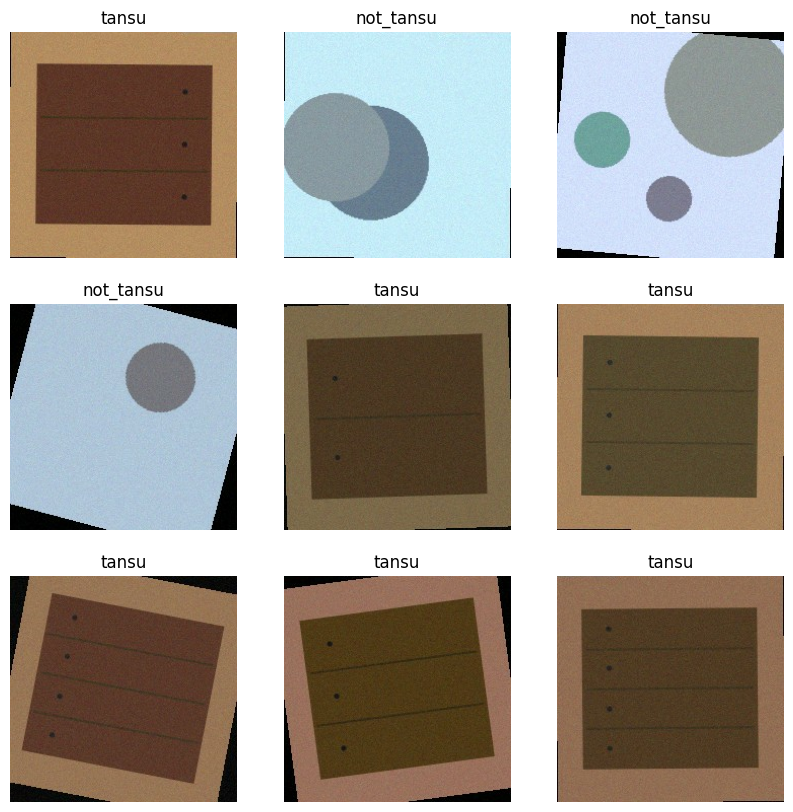

In [17]:
# パフォーマンス最適化: キャッシュとプリフェッチ
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# サンプル画像を表示して確認
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
plt.show()

In [18]:
# シンプルなモデル構築（理解しやすく最小構成）
# 1) 軽いデータ拡張
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.06),
], name='data_augmentation')

# 2) バックボーン: EfficientNetB0 を優先、なければ MobileNetV2
try:
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=img_size + (3,), include_top=False, weights='imagenet')
    from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input
    print('Using EfficientNetB0')
except Exception:
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=img_size + (3,), include_top=False, weights='imagenet')
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input
    print('Using MobileNetV2')

base_model.trainable = False  # まずはバックボーンを凍結してヘッドだけ学習

# 3) 簡単なヘッド
inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

# 4) コンパイル（シンプルに BCE と Adam）
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Using EfficientNetB0


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [19]:
# シンプルな学習セル: 最小限のコールバックで学習
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_tansu_model.h5', save_best_only=True)
]

# 少数エポックから始めて様子を見る（実データで本気で学習する場合は増やす）
epochs = 10

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

# NOTE: モデルの最良重みは 'best_tansu_model.h5' に保存されます。

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.5339 - loss: 0.8435

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5000 - loss: 0.8587 - val_accuracy: 0.5000 - val_loss: 0.8713
Epoch 2/10
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.4806 - loss: 0.8003

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 834ms/step - accuracy: 0.4500 - loss: 0.8433 - val_accuracy: 0.5000 - val_loss: 0.8431
Epoch 3/10
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.4824 - loss: 0.8180

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - accuracy: 0.4563 - loss: 0.8231 - val_accuracy: 0.5000 - val_loss: 0.8160
Epoch 4/10
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5158 - loss: 0.7859

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.5063 - loss: 0.7847 - val_accuracy: 0.5000 - val_loss: 0.7894
Epoch 5/10
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5567 - loss: 0.7521

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - accuracy: 0.5125 - loss: 0.7770 - val_accuracy: 0.5000 - val_loss: 0.7639
Epoch 6/10
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5654 - loss: 0.7254

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 891ms/step - accuracy: 0.5562 - loss: 0.7432 - val_accuracy: 0.5000 - val_loss: 0.7391
Epoch 7/10
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.5392 - loss: 0.7352

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 970ms/step - accuracy: 0.5188 - loss: 0.7425 - val_accuracy: 0.5000 - val_loss: 0.7147
Epoch 8/10
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.5505 - loss: 0.6867

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5312 - loss: 0.7007 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 9/10
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.6366 - loss: 0.6739

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 979ms/step - accuracy: 0.6125 - loss: 0.6804 - val_accuracy: 0.5000 - val_loss: 0.6685
Epoch 10/10
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.6177 - loss: 0.6482

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5938 - loss: 0.6723 - val_accuracy: 0.5000 - val_loss: 0.6466


In [20]:
import os
save_fname = 'tansu_detector.keras'
# ローカル（カレントディレクトリ）に保存します
save_path = os.path.join(os.getcwd(), save_fname)
try:
    model.save(save_path)
    print('モデルを保存しました:', save_path)
except Exception as e:
    print('モデル保存に失敗しました:', e)
    # フォールバックで .h5 形式で保存を試みる
    try:
        fallback = os.path.join(os.getcwd(), 'best_tansu_model.h5')
        model.save(fallback)
        print('Fallback: モデルを保存しました:', fallback)
    except Exception as e2:
        print('Fallback 保存も失敗しました:', e2)


モデルを保存しました: c:\Users\tatuy\Documents\Github\kennkyu\tansu_detector.keras
